<h1>Data input</h1>

Begin by importing the help functions in the 'proto' package:

In [1]:
import fit_functions

Define data files: 
 - spectrum: simple 3-column ASCII file
 - wavelength regions to be ignored by fit: simple 2-column ASCII file
 - model to be fitted: ASCII file in specfit's IRAF database format.

In [2]:
datafile = "../data/n5548/n5548_mean_g130mb4.asc"
regionsfile = "../data/n5548/n5548_lyalpha_sample.dat"
modelfile = "../data/n5548/sfn5548_lyalpha2"

Read spectrum and regions files. 

Spectrum is returned as an object that encapsulates wavelength, flux, and error arrays. 

Mask is a float numpy array with 1's for good data points and 0's for ignored data points.

In [3]:
spectrum, mask = fit_functions.read_file(datafile, regions=regionsfile)

Read model:

In [4]:
model = fit_functions.read_model(modelfile)

Model is a list of functions defined in astropy.modeling.models. 

In [5]:
print(model)

[<powerlaw(amplitude=4.404877e-14, x_0=0.0791134, alpha=1.0)>, <gaussian(amplitude=2e-14, mean=1195.006, stddev=861.4926)>, <gaussian(amplitude=1.438015e-14, mean=1226.392, stddev=861.4926)>, <gaussian(amplitude=2.02e-13, mean=1236.729, stddev=255.4998)>, <gaussian(amplitude=5.474183e-13, mean=1235.996, stddev=861.4926)>, <gaussian(amplitude=2.22193e-12, mean=1235.138, stddev=3040.59)>, <gaussian(amplitude=2.951626e-12, mean=1231.589, stddev=8133.099)>, <gaussian(amplitude=1.705819e-12, mean=1237.643, stddev=18183.71)>, <gaussian(amplitude=1.217935e-14, mean=1259.753, stddev=255.4998)>, <gaussian(amplitude=1.217935e-14, mean=1263.803, stddev=255.4998)>, <gaussian(amplitude=6.219548e-15, mean=1259.533, stddev=861.4926)>, <gaussian(amplitude=6.219548e-15, mean=1263.582, stddev=861.4926)>, <gaussian(amplitude=2.029655e-13, mean=1258.659, stddev=3040.59)>, <gaussian(amplitude=2.029655e-13, mean=1262.705, stddev=3040.59)>, <gaussian(amplitude=1.203628e-13, mean=1255.042, stddev=8133.099)>, 

<h1>Fitting</h1>

So far, we have worked on having the data ingested into appropriate formats acceptable by the astropy fitting stuff.

Now, to fit the multiple components in the model simultaneously, we have to build a compound model. An astropy compound model is just a combination of all the functions in the model, using as combination operators such things as additin, multiplication, and others.

Example: 

<code>compound_model = models.PowerLaw1D(1.,1.) + models.Gaussian1D(1.,1.,1.)</code>

will create an instance of a compound model with two components.

We build our component model by calling a function in the fit_functions module that will just add together all the functions in the input list:

In [6]:
compound_model = fit_functions.compoundModel(model)

In [7]:
print(compound_model)

Model: CompoundModel19
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
    amplitude_0    x_0_0   alpha_0 amplitude_1 ... amplitude_20 mean_20  stddev_20
    ------------ --------- ------- ----------- ... ------------ -------- ---------
    4.404877e-14 0.0791134     1.0       2e-14 ... -5.95592e-14 1257.333  2561.741





The actual fitting then is a very simple operation. 

First, we instantiate a fitter engine:

In [10]:
import astropy.modeling.fitting as fitting

In [11]:
fitter = fitting.LevMarLSQFitter()

In this example, we have errors for the data points, so we can use their inverse as weights for the fit:

In [12]:
w = mask / spectrum.e.data

And rhe fit itself is made by just calling the fitter instance with the data, weights, and some control parameters if needed:

In [13]:
fit_result = fitter(compound_model, spectrum.x.data, spectrum.y.data, weights=w, acc=1.E-6, maxiter=1000)

/Users/busko/Projects/software/miniconda/lib/python2.7/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


The warning is something generated by astropy. Seems to be harmless in this case.

And the result is another instance of a compound model, with the fitted values set into the  parameter values:

In [14]:
print(fit_result)

Model: CompoundModel19
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
       amplitude_0          x_0_0       ...    mean_20      stddev_20  
    ----------------- ----------------- ... ------------- -------------
    6.52014513446e-16 0.000125557528662 ... 1249.30276325 3014.06024088


In [16]:
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

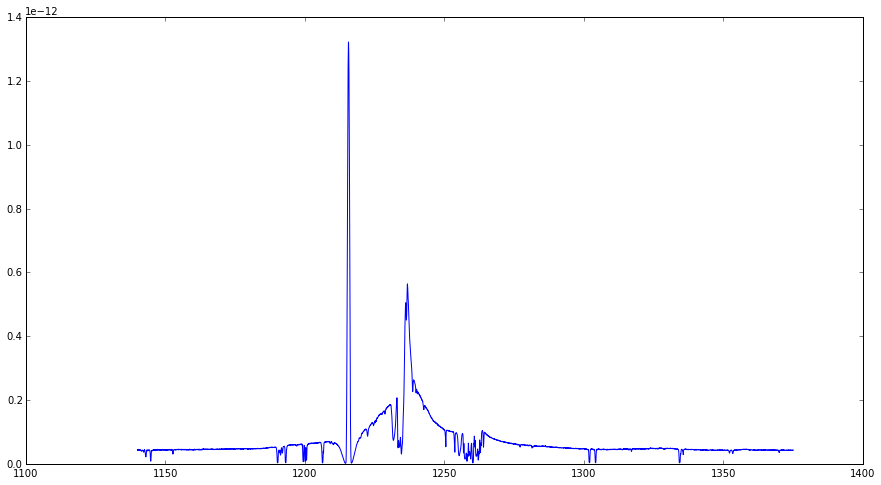

In [33]:
plt.gcf().set_size_inches(15.,8.)
plt.plot(spectrum.x.data, spectrum.y.data, 'b')

In [36]:
model_y = compound_model(spectrum.x.data)

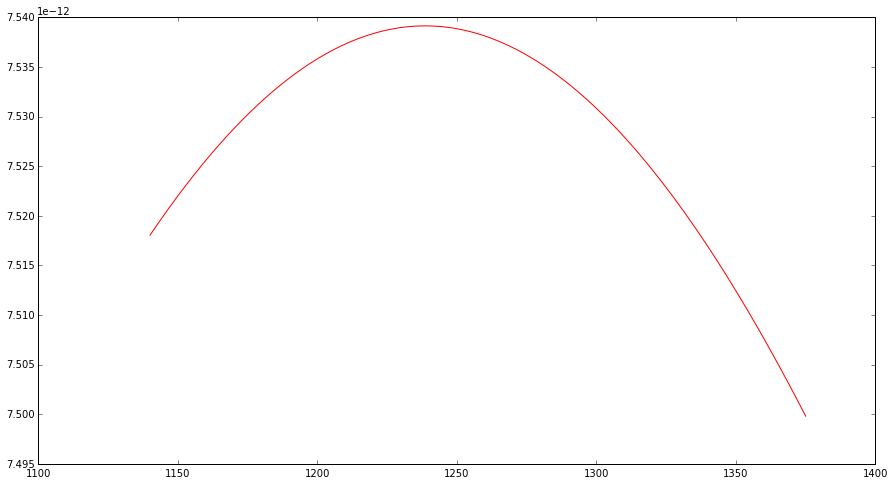

In [38]:
plt.gcf().set_size_inches(15.,8.)
plt.plot(spectrum.x.data, model_y, 'r')